This tutorial was modified from [time-series-forecasting-CNN](https://github.com/drewthayer/time-series-forecasting-CNN)

**Business problem:** Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption.

**Data**: 'Household Power Consumption' dataset from UCI machine learning repository

*  household power consumption
*  units: kilowatts
*  frequency: daily
*  time range: 2006 to 2010

**Strategy**:

*  Time-sequence forecasting: autoregression
  *   be able to predict a forecast for y number of days into the future based on x number of days up to current (e.g. predict next week from this week)
*  Convolutional Neural Network
  * low-bias model that can learn non-linear relationships
  * implemented in Keras

**Model evaluation**:

* evaluate each forecast day individually
* use RMSE, metric in the data units (kilowatts)

## Prepare data

* Download ata
* Clean data
* Downsample data

### Download data

In [ ]:
!wget -O /content/household_power_consumption.zip https://github.com/yeyimilk/time-series-forecasting-CNN/raw/master/data/household_power_consumption.zip

!unzip /content/household_power_consumption.zip

--2024-05-22 19:01:03--  https://github.com/yeyimilk/time-series-forecasting-CNN/raw/master/data/household_power_consumption.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yeyimilk/time-series-forecasting-CNN/master/data/household_power_consumption.zip [following]
--2024-05-22 19:01:04--  https://raw.githubusercontent.com/yeyimilk/time-series-forecasting-CNN/master/data/household_power_consumption.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/zip]
Saving to: ‘/content/household_power_consumption.zip’

/content/household_ 100%[===================>]  19.68M  

In [ ]:
import os
from zipfile import ZipFile

file_path = '/content/household_power_consumption.zip'
if os.path.exists(file_path):
    try:
        with ZipFile(file_path, 'r') as zip_ref:
            print("This is a valid zip file")
    except:
        print("The file is not a valid zip file")
else:
    print("File not found")


This is a valid zip file


### Clean data

*   pandas dataframe
*   set datetime indices
*   impute missing values
*   feature engineering
*   List item


In [ ]:
import pandas as pd

# Original data overview
dir = '/content' # google default folder
fname = 'household_power_consumption.txt'
dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')

dataset.head()

<ipython-input-24-045fd945cfb3>:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')
<ipython-input-24-045fd945cfb3>:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
import numpy as np
import pandas as pd
import pickle

def df_impute_previous_index(df, idx_delta, nan_tag): # too slow
    ''' imputes missing values based on prior index in pandas dataframe,
        uses np array for speed. Preserves column names and indices.
        inputs:
            df:         pandas dataframe
            idx_delta:  int, number of indices to find prior value to impute
            nan_tag:    np.nan OR string, e.g. 'nan' or 'na'

        output:
            new_df: pandas dataframe, same size as df '''
    vals = df.values
    for row in range(vals.shape[0]):
        for col in range(vals.shape[1]):
            if vals[row,col] == nan_tag:
                vals[row,col] = vals[row - idx_delta, col]
    new_df = pd.DataFrame(data=vals, index=df.index, columns=df.columns)
    return new_df

def load_and_clean_data():
  dir = '/content' # google default folder
  fname = 'household_power_consumption.txt'
  dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')

  # CLEAN DATA
  # replace missing value with nan
  dataset.replace('?', np.nan, inplace=True) # could use from numpy import nan, nan
  # set data type as int
  dataset = dataset.astype('float32')

  # impute missing values: value of 24 hours previous
  idx_delta = 60*24 #index of 24 hours previous, timeset interval = 1 minute
  data_clean = df_impute_previous_index(dataset, idx_delta, np.nan)

  # engineer 4th sub_metering feature
  data_clean['Sub_metering_4'] = (data_clean.Global_active_power * 1000 / 60) - (data_clean.Sub_metering_1 + data_clean.Sub_metering_2 + data_clean.Sub_metering_3)

  # SAVE DATA TO PKL
  new_file_name = f'{dir}/household_power_consumption.pkl'
  with open(new_file_name, 'wb') as f:
      pickle.dump(data_clean, f)
  print(f'data written to {new_file_name}')

load_and_clean_data()

<ipython-input-25-8d658e85d69b>:26: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')
<ipython-input-25-8d658e85d69b>:26: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')


data written to /content/household_power_consumption.pkl


### Downsample data

In [ ]:
import pandas as pd
import pickle
import os

def downsample_df(df, time_alias):
    ''' daily: 'D' '''
    group = df.resample(time_alias)
    df_resampled = group.sum()
    return df_resampled

def save_to_pickle(data, dir, fname):
    with open(os.path.join(dir, fname), 'wb') as f:
        pickle.dump(data, f)
    print('{} written to pkl'.format(fname))

def load_from_pickle(dir, fname):
    with open(os.path.join(dir,fname), 'rb') as f:
        data = pickle.load(f)
    return data

def downsample_data():
  dir = '/content'
  fname = 'household_power_consumption.pkl'
  with open(os.path.join(dir,fname), 'rb') as f:
      data = pickle.load(f)

  data_resamp = downsample_df(data, 'D')

  # SAVE DATA
  save_to_pickle(data_resamp, dir, 'household_power_consumption_daily.pkl')

downsample_data()

household_power_consumption_daily.pkl written to pkl


## Prepare training and validation sets
### train and test split

* train 2006:2009
* validate 2010
* data in standard weeks (saturday to sunday) for easy interpretation
* training set duration: 1113 days, 159.0 weeks
* test set duration: 322 days, 46.0 weeks

### time series forecast training data
* training features in sets of 7-day intervals
* training targets in sets of 7-day intervals, offset by 7 days (so X_train[7,:] = y_train[0,:], and so on...)

In [ ]:
dir = '/content'
file_name = 'household_power_consumption_daily'
data = load_from_pickle(dir, f'{file_name}.pkl')
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781


In [ ]:
def train_test_split():
    # LOAD DATA
    dir = '/content'
    file_name = 'household_power_consumption_daily'
    data = load_from_pickle(dir, f'{file_name}.pkl')

    # SPLIT DATA
    # using standard weeks sunday - saturday
    # first sunday in dataset:
    day1_train = '2006-12-17'
    # first sunday in 2010:
    day1_test = '2010-1-3'
    # last saturday in dataset:
    day_last_test = '2010-11-20'

    data_train = data[data.index >= day1_train]
    data_train = data_train[data_train.index < day1_test]
    data_test = data[data.index >= day1_test]
    data_test = data_test[data_test.index <= day_last_test]

    # METRICS
    ndays_train = data_train.shape[0]
    ndays_test = data_test.shape[0]
    print('\ntraining set duration: {} days, {} weeks'.format(ndays_train, ndays_train/7))
    print('test set duration: {} days, {} weeks\n'.format(ndays_test, ndays_test/7))

    save_to_pickle(data_train, dir, f'{file_name}_train.pkl')
    save_to_pickle(data_test, dir, f'{file_name}_test.pkl')

train_test_split()


training set duration: 1113 days, 159.0 weeks
test set duration: 322 days, 46.0 weeks

household_power_consumption_daily_train.pkl written to pkl
household_power_consumption_daily_test.pkl written to pkl


## Train model

* Model training
* Model evaluation
* Results visualization

In [ ]:
import pandas as pd
import numpy as np
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

def build_staggered_Xy_1d(data, feature_idx, n_input=7, n_output=7):
    ''' feature_idx:    int     index of feature in array '''
    X, y = [],[]
    in_start = 0
    # step over timeseries: 'in' and 'out' series, lengths = n_input, n_output
    # series are contiguous so in_end = out_start
    for i in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_output
        if out_end < len(data): # prevent iterating too far
            x_input = data[in_start:in_end, feature_idx]
            x_input = x_input.reshape((len(x_input), 1)) # column vector
            X.append(x_input)
            y.append(data[in_end:out_end, feature_idx])
        # step forward one unit
        in_start += 1

    return np.array(X), np.array(y)

def build_model(X_train, y_train):
    # define parameters
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    # define model

    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    return model

def train_model(feature_idx=0, verbose = 1):
    dir = '/content'
    file_name = 'household_power_consumption_daily'
    train_df = load_from_pickle(dir, f'{file_name}_train.pkl')
    test_df = load_from_pickle(dir, f'{file_name}_test.pkl')

    # TRANSFORM to np array
    # columns: ['Global_active_power', 'Global_reactive_power', 'Voltage',
    #   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
    #   'Sub_metering_3', 'Sub_metering_4']
    train_data = train_df.values
    test_data = test_df.values

    # TRANSFORM to CNN input shape
    # 1D CNN input shape: [n_samples, n_timesteps_per_sample, n_features]
    #                       e.g. [159 (week), 7(days), 1 (feature)] (or 8 features)
    train_data = train_data.reshape(int(train_data.shape[0]/7), 7, train_data.shape[1])
    test_data = test_data.reshape(int(test_data.shape[0]/7), 7, test_data.shape[1])

    print(f"train data shape: {train_data.shape}, test data shape: {test_data.shape}")

    # flatten back
    train_data_flat = train_data.reshape((train_data.shape[0]*train_data.shape[1], train_data.shape[2]))

    # convert timeseries into staggered inputs and outputs
    X_train, y_train = build_staggered_Xy_1d(train_data_flat, feature_idx=feature_idx, n_input=7, n_output=7)
    print(f"X_train data shape: {X_train.shape}, y_train data shape: {y_train.shape}")

    save_to_pickle(X_train, dir, f'X_train_{feature_idx}.pkl')
    save_to_pickle(y_train, dir, f'y_train_{feature_idx}.pkl')

    # train the model
    model = build_model(X_train, y_train)
    # # fit network
    epochs, batch_size = 20, 4
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # serialize and save model
    model_json = model.to_json()
    with open(f'{dir}/{file_name}_model_{feature_idx}.json', 'w') as f:
        json.dump(model_json, f)

    # serialize weights to hdf5
    model.save_weights(f'{dir}/{file_name}_model_{feature_idx}.h5')
    print('model and weights written to disk')

train_model()

train data shape: (159, 7, 8), test data shape: (46, 7, 8)
X_train data shape: (1099, 7, 1), y_train data shape: (1099, 7)
X_train_0.pkl written to pkl
y_train_0.pkl written to pkl
Epoch 1/20
275/275 [==============================] - 2s 2ms/step - loss: 1899332.8750
Epoch 2/20
275/275 [==============================] - 0s 2ms/step - loss: 301806.0000
Epoch 3/20
275/275 [==============================] - 0s 2ms/step - loss: 287413.5938
Epoch 4/20
275/275 [==============================] - 0s 2ms/step - loss: 287221.4375
Epoch 5/20
275/275 [==============================] - 0s 2ms/step - loss: 285765.7500
Epoch 6/20
275/275 [==============================] - 0s 2ms/step - loss: 284887.6562
Epoch 7/20
275/275 [==============================] - 0s 2ms/step - loss: 284613.9062
Epoch 8/20
275/275 [==============================] - 0s 2ms/step - loss: 283634.0938
Epoch 9/20
275/275 [==============================] - 0s 2ms/step - loss: 283164.2188
Epoch 10/20
275/275 [=======================

In [ ]:
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json
from tqdm import tqdm

def forecast(model, X_train, n_input, verbose):
    # grab the last week in training data
    input_x = X_train[-n_input:,0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # predict the next week
    model.compile(loss='mse', optimizer='adam')
    y_hat = model.predict(input_x, verbose=verbose)
    return y_hat

def walk_forward_validation(data, model, n_input, verbose):
    ''' walk-forward validation
        advances one unit at a time for a fixed set (e.g. daily, by week)
        inputs
            data        np array    must be shape that model has been trained on
            model       keras model with .predict() method and verbose parameter
            n_input     int         number of units to include in each input set
        outputs
            true        list        true values
            pred        list        predicted values, same length as true
        caveats
            data must match shape that model was trained on
            model must be trained on same n_input

    '''
    true = []
    pred = []
    c = 0
    for i in tqdm(range(len(data) - (2*n_input))):

        input = data[c:c + n_input]
        input = input.reshape(1, len(input), 1)
        y_true = data[c + n_input: c + 2*n_input]
        y_hat = model.predict(input, verbose=verbose)
        true.append(y_true)
        pred.append(y_hat.squeeze()) # drop one dimension
        verbose and print(c)
        c += 1

    return true, pred

def calc_rmse_error(true, pred):
    ''' calc mse error from lists of true and predicted values
        uses sklearn.metrics.mean_squared_error()
        input lists can contain ints or arrays'''
    errors = []
    for y_true, y_hat in zip(true, pred):
        mse = mean_squared_error(y_true, y_hat)
        rmse = np.sqrt(mse)
        errors.append(rmse)
    return np.array(errors)

def evaluate_model(feature_idx=0, verbose=1):
    dir = '/content'
    file_name = 'household_power_consumption_daily'

    # load model and compile
    with open(f'{dir}/{file_name}_model_{feature_idx}.json', 'r') as f:
        model_json = json.load(f)
    model = model_from_json(model_json)
    model.compile(loss='mse', optimizer='adam')

    # load model weights
    model.load_weights(f'{dir}/{file_name}_model_{feature_idx}.h5')
    print('model and weights loaded')

    # load data: train set in inputs/outputs, test set
    X_train = load_from_pickle(dir, f'X_train_{feature_idx}.pkl')
    y_train = load_from_pickle(dir, f'y_train_{feature_idx}.pkl')
    test_df = load_from_pickle(dir, f'{file_name}_test.pkl')
    test = test_df.values

    # evaluate on test set: univariate
    feat_col = 0
    test = test[:,feat_col]
    true, pred = walk_forward_validation(test, model, n_input=7, verbose=verbose)

    # score predictions, save to file
    errors = calc_rmse_error(true, pred)
    save_to_pickle((true, pred, errors), dir, f'output_{feature_idx}.pkl')

evaluate_model(verbose=0)

model and weights loaded


100%|██████████| 308/308 [00:23<00:00, 12.99it/s]


output_0.pkl written to pkl


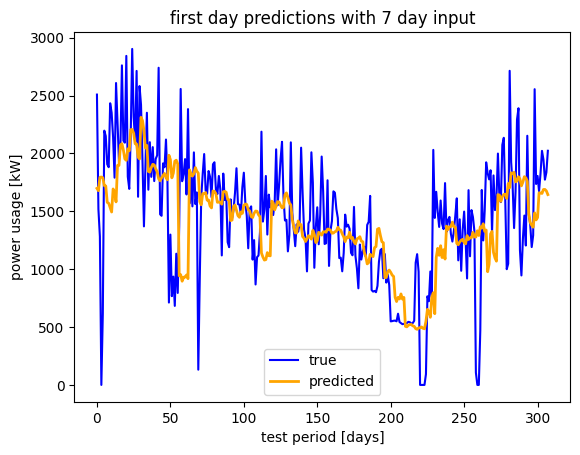

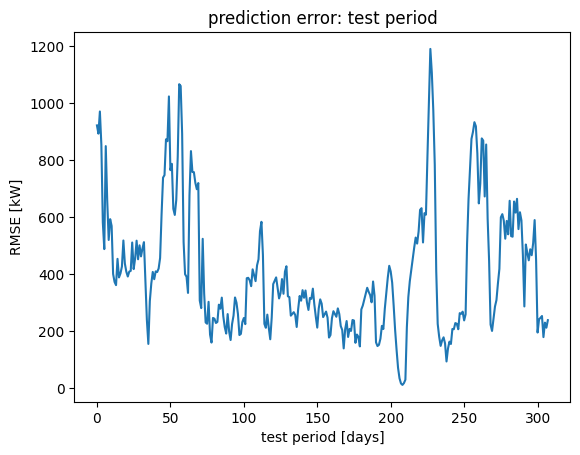

In [ ]:
import matplotlib.pyplot as plt

def timeseries_from_staggered_timeseries_sets(data, n):
    ''' for staggered timeseries where sets are equal length, advancing by one unit '''
    # indices that contain independent sets of values
    ii = np.linspace(n, len(data), int(len(data)/ 7))
    ii = np.insert(ii, 0, 0)
    ii = np.delete(ii, -1)
    ii = ii.astype(int)

    yy = []
    for i in ii:
        yy.append(list(data[i])) # append lists
        flat = [item for sublist in yy for item in sublist]
    return flat

def check_output(feature_idx=0):
    # load output and test set
    dir = '/content'
    file_name = 'household_power_consumption_daily'
    (true, pred, errors) = load_from_pickle(dir, f'output_{feature_idx}.pkl')
    test_df = load_from_pickle(dir, f'{file_name}_test.pkl')
    test = test_df.values

    # get single timseries for true and pred (pred is first day predition)
    n_days = 7
    yy_true = timeseries_from_staggered_timeseries_sets(true, n_days)
    yy_pred = timeseries_from_staggered_timeseries_sets(pred, n_days)

    # plot true vs predicted
    fname = 'output_predictions'
    plt.figure()
    plt.plot(yy_true, 'b', label='true')
    plt.plot(yy_pred, 'orange', label='predicted', linewidth=2)
    plt.ylabel('power usage [kW]')
    plt.xlabel('test period [days]')
    plt.legend()
    plt.title('first day predictions with {} day input'.format(n_days))
    # plt.savefig(os.path.join(dir, fname + '.png'), dpi=250)
    plt.plot()
    # plt.close()


    # plot errors
    fname = 'output_rmse'
    plt.figure()
    plt.plot(errors)
    plt.ylabel('RMSE [kW]')
    plt.xlabel('test period [days]')
    plt.title('prediction error: test period')
    # plt.savefig(os.path.join(dir, fname + '.png'), dpi=250)
    plt.plot()
    # plt.close()

check_output()

### Your turn


*   Try to modified the model, for example, change epochs, batch size, additional layers, Dropout
*   Try to change the data, features to train and prediction, timestamp length

